<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/process_flow_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up the Colab page to use neqsim
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
! pip install neqsim -q
!pip install pyflowsheet
!pip install pathfinding==0.0.4 # Install the compatible pathfinding version.

#Documentation
In the following example we will use [neqsim](equinor.github.io/neqsimhome/) and [pyflowsheet](https://github.com/Nukleon84/pyflowsheet) to generate process flow diagrams.


In [2]:
import pandas as pd
from neqsim.process import openprocess
from neqsim.thermo import createfluid,fluid_df,TPflash
from neqsim.process.processTools import valve,stream,simplereservoir,clearProcess,runProcess, getProcess,separator3phase,heater,separator,compressor,setpoint,recycle,mixer,pump

# Uncomment to create alternative well stream
wellStreamComposition = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20"],
        'MolarComposition[-]':  [0.53, 3.3, 72.98, 7.68, 4.1, 0.7, 1.42, 0.54, 0.67, 0.85, 1.33, 1.33, 0.78, 0.61, 0.42, 0.33, 0.42, 0.24, 0.3, 0.17, 0.21, 0.15, 0.15, 0.8],
        'MolarMass[kg/mol]': [None,None, None,None,None,None,None,None,None,None,0.0913, 0.1041, 0.1188, 0.136, 0.150, 0.164, 0.179, 0.188, 0.204, 0.216, 0.236, 0.253, 0.27, 0.391],
        'RelativeDensity[-]': [None,None, None,None,None,None,None,None,None,None, 0.746, 0.768, 0.79, 0.787, 0.793, 0.804, 0.817, 0.83, 0.835, 0.843, 0.837, 0.84, 0.85, 0.877]
  }

wellStreamCompositiondf = pd.DataFrame(wellStreamComposition)
wellStreamFluid = fluid_df(wellStreamCompositiondf)

wellStream = stream(wellStreamFluid)
wellStream.setName("WellStream")
wellStream.setFlowRate(15.63, "MSm3/day")
wellStream.setTemperature(40.0, "C")
wellStream.setPressure(120.0, "bara")

wellStream.run()



#Create process flow diagram
The creation of diagrams should be automated with neqsim. Here is an example of using the pyflowsheet library for creating a process flow diagram.

/usr/local/lib/python3.10/dist-packages/matplotlib/table.py:808: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],


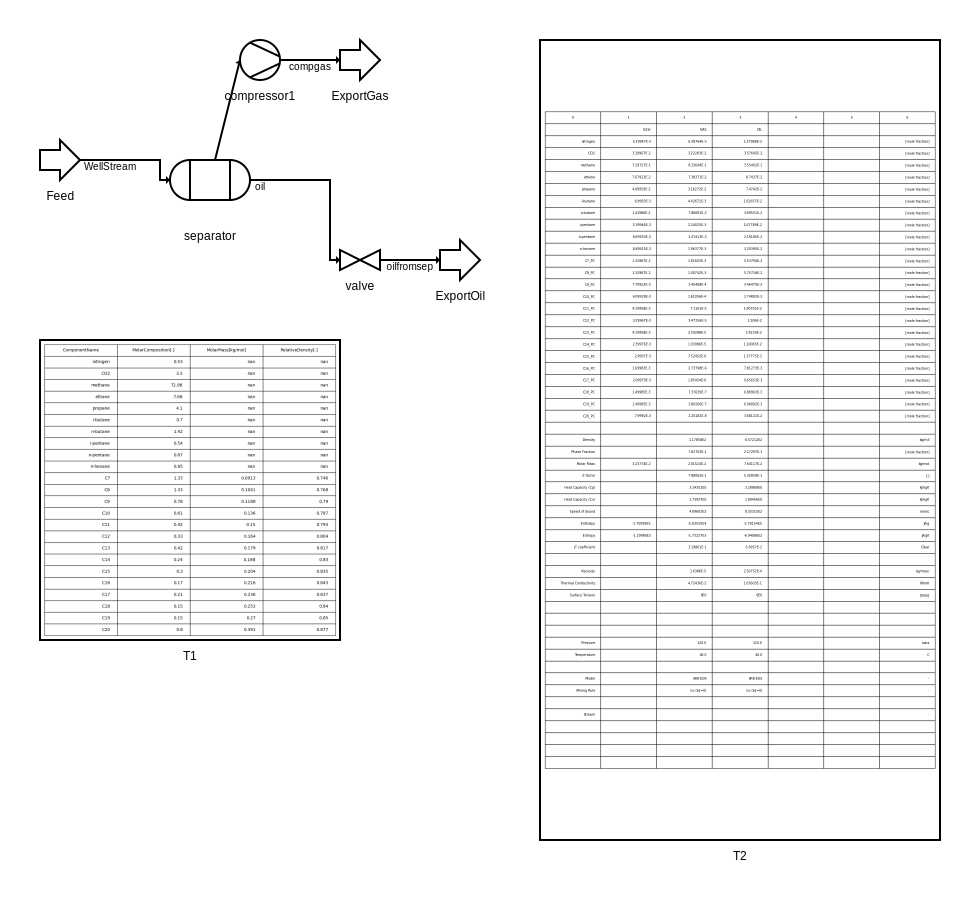

In [3]:
from pyflowsheet import Flowsheet, UnitOperation, Distillation, Vessel, BlackBox, Pump, Stream, StreamFlag, Valve,HeatExchanger, SvgContext, Port, Compressor
from pyflowsheet.internals import Tubes,RandomPacking
from IPython.core.display import SVG, HTML
from neqsim.thermo import dataFrame
import matplotlib.pyplot as plt

pfd= Flowsheet("V100","Block Flow Diagram", "Demo Flowsheet for showing block-flow diagram style")
Feed= StreamFlag("Feed", "", position=(0,100))

InletSep = Vessel("separator","Horizontal Vessel", position=(150,100), angle=90, size=(40,80))
InletSep.ports["Out2"] = Port("Out2", InletSep, (0.5, 0.5), (0, 0), intent="out")

compressor1 = Compressor("compressor1","Compressor", position=(200,0), size=(40,40))

ExportGas= StreamFlag("ExportGas", "", position=(300,0))

valve1 = Valve("valve","Valve", position=(300,210),size=(40,20))

ExportOil= StreamFlag("ExportOil", "", position=(400,200))

from pyflowsheet.annotations.table import Table
T1 = Table("T1", "DemoTable", data=wellStreamCompositiondf, position=(0,300), size=(300,300),figsize=(10,10))

exporGasdf = pd.DataFrame(wellStream.getResultTable())
T2 = Table("T2", "DemoTable2", data=dataFrame(wellStream.getFluid()), position=(500,0), size=(400,800),figsize=(12,20))

pfd.addUnits( [Feed, InletSep, compressor1,ExportGas, valve1, ExportOil] )
pfd.addAnnotations([T1, T2])

pfd.connect("WellStream", Feed["Out"], InletSep["In"] )
pfd.streams["WellStream"].labelOffset=(20,10)

pfd.connect("gasstream", InletSep["Out2"], compressor1["In"] )

pfd.connect("compgas", compressor1["Out"], ExportGas["In"] )
pfd.streams["compgas"].labelOffset=(20,10)

pfd.connect("oilfromsep", valve1["Out"], ExportOil["In"] )
pfd.streams["oilfromsep"].labelOffset=(20,10)

pfd.connect("oil", InletSep["Out"], valve1["In"] )

ctx= SvgContext("blockflowprocess.svg")
img = pfd.draw(ctx)
SVG(img.render(scale=1))